In [2]:
# ==============================
# 1. IMPORTS
# ==============================
import os
import cv2
import numpy as np
from time import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# ==============================
# 2. PARAMETERS
# ==============================
train_dir = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
external_test_dir = '/kaggle/input/asl-alphabet-test'

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'nothing', 'space', 'del']

num_classes = len(classes)
learning_rate = 1e-4 
input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

# ==============================
# 3. DATA GENERATORS (RESNET PREPROCESSING)
# ==============================
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # ResNet specific preprocessing (-1 to 1)
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,   # Keep False for ASL
    fill_mode='nearest',
    validation_split=0.1
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# ==============================
# 4. MODEL CREATION (RESNET50V2)
# ==============================
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze bottom 90%, Unfreeze top 10%
base_model.trainable = True
fine_tune_at = int(len(base_model.layers) * 0.9)

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

adam = Adam(learning_rate=learning_rate)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ==============================
# 5. TRAINING WITH CALLBACKS
# ==============================
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    min_lr=1e-6, 
    verbose=1
)

start = time()
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
train_time = time() - start
print(f"\nTraining completed in {train_time:.2f} seconds.")

model.save("asl_resnet50v2_optimized.keras")
print("Model saved successfully as 'asl_resnet50v2_optimized.keras'!")

# ==============================
# 6. PLOT TRAINING HISTORY (NEW SECTION)
# ==============================
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.show()

plot_history(history)

# ==============================
# 7. EVALUATION ON VALIDATION SET
# ==============================
def evaluate_generator(generator, title="Dataset"):
    loss, acc = model.evaluate(generator, verbose=1)
    print(f"\n{title} - Accuracy: {acc:.4f}, Loss: {loss:.4f}")

    y_pred = model.predict(generator, verbose=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = generator.classes

    cm = confusion_matrix(y_true_labels, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    
    plt.figure(figsize=(14, 14))
    disp.plot(xticks_rotation='vertical', cmap='Blues', ax=plt.gca())
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    print(f"\nCLASSIFICATION REPORT - {title}")
    print(classification_report(y_true_labels, y_pred_labels, target_names=classes))

evaluate_generator(val_generator, title="Validation Set")

# ==============================
# 8. LOAD EXTERNAL TEST DATA
# ==============================
def load_external_test_data(test_dir, img_size=(128, 128)):
    images, labels = [], []
    
    if not os.path.exists(test_dir):
        print(f"Error: Directory {test_dir} not found.")
        return np.array([]), np.array([])

    for folder in os.listdir(test_dir):
        if folder not in classes:
            continue
            
        label_idx = classes.index(folder)
        folder_path = os.path.join(test_dir, folder)
        
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            
            img = cv2.imread(img_path)
            
            if img is None:
                continue
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            
            # ResNet Preprocessing
            img = img.astype('float32')
            img = preprocess_input(img) 
            
            images.append(img)
            labels.append(label_idx)
            
    images = np.array(images)
    labels = to_categorical(labels, num_classes=num_classes)
    
    print(f"\nLoaded {images.shape[0]} external test images. Shape = {images.shape}")
    return images, labels

x_test_external, y_test_external = load_external_test_data(external_test_dir, img_size=input_shape[:2])

# ==============================
# 9. EVALUATE ON EXTERNAL TEST SET
# ==============================
def evaluate_on_arrays(x_data, y_data, title="External Test Set"):
    if x_data.size == 0:
        print("No data to evaluate.")
        return

    loss, acc = model.evaluate(x_data, y_data, verbose=1)
    print(f"\n{title} - Accuracy: {acc:.4f}, Loss: {loss:.4f}")

    y_pred = model.predict(x_data, verbose=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_data, axis=1)

    cm = confusion_matrix(y_true_labels, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    
    plt.figure(figsize=(14, 14))
    disp.plot(xticks_rotation='vertical', cmap='Blues', ax=plt.gca())
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    print(f"\nCLASSIFICATION REPORT - {title}")
    print(classification_report(y_true_labels, y_pred_labels, target_names=classes))

evaluate_on_arrays(x_test_external, y_test_external, title="External Test Set")

In [3]:
# ==============================
# 1. IMPORTS
# ==============================
import os
import cv2
import numpy as np
from time import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split


In [4]:
# ==============================
# 2. PARAMETERS
# ==============================
train_dir = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
external_test_dir = '/kaggle/input/asl-alphabet-test'

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'nothing', 'space', 'del']

num_classes = len(classes)
learning_rate = 1e-4 
input_shape = (128, 128, 3)
batch_size = 32
epochs = 20


In [5]:
# ==============================
# 3. DATA GENERATORS (RESNET PREPROCESSING)
# ==============================
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # ResNet specific preprocessing (-1 to 1)
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,   # Keep False for ASL
    fill_mode='nearest',
    validation_split=0.1
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


In [6]:
# ==============================
# 4. MODEL CREATION (RESNET50V2)
# ==============================
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze bottom 90%, Unfreeze top 10%
base_model.trainable = True
fine_tune_at = int(len(base_model.layers) * 0.9)

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

adam = Adam(learning_rate=learning_rate)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


I0000 00:00:1764730675.955160      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764730675.955824      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,104,989 (91.95 MB)

 Trainable params: 8,415,773 (32.10 MB)

 Non-trainable params: 15,689,216 (59.85 MB)

In [7]:
# ==============================
# 5. TRAINING WITH CALLBACKS
# ==============================
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    min_lr=1e-6, 
    verbose=1
)

start = time()
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
train_time = time() - start
print(f"\nTraining completed in {train_time:.2f} seconds.")

model.save("asl_resnet50v2_optimized.keras")
print("Model saved successfully as 'asl_resnet50v2_optimized.keras'!")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1764730701.781312     136 service.cc:148] XLA service 0x7df04c002cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764730701.782242     136 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764730701.782263     136 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764730703.365252     136 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/2447 ━━━━━━━━━━━━━━━━━━━━ 2:34 63ms/step - accuracy: 0.0469 - loss: 4.5893   

I0000 00:00:1764730710.265763     136 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2447/2447 ━━━━━━━━━━━━━━━━━━━━ 807s 323ms/step - accuracy: 0.7152 - loss: 1.0455 - val_accuracy: 0.8985 - val_loss: 0.3274 - learning_rate: 1.0000e-04
Epoch 2/20
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 447s 183ms/step - accuracy: 0.9634 - loss: 0.1175 - val_accuracy: 0.9125 - val_loss: 0.3381 - learning_rate: 1.0000e-04
Epoch 3/20
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 426s 174ms/step - accuracy: 0.9744 - loss: 0.0832 - val_accuracy: 0.9167 - val_loss: 0.3441 - learning_rate: 1.0000e-04
Epoch 4/20
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9819 - loss: 0.0594
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 442s 181ms/step - accuracy: 0.9819 - loss: 0.0594 - val_accuracy: 0.9017 - val_loss: 0.4658 - learning_rate: 1.0000e-04
Epoch 5/20
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 428s 175ms/step - accuracy: 0.9884 - loss: 0.0388 - val_accuracy: 0.9193 - val_loss: 0.3611 - learning_rate: 2.0000e-05
Epoch 6/20
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 436

In [8]:
model.save("asl_resnet50v2_optimized.h5")

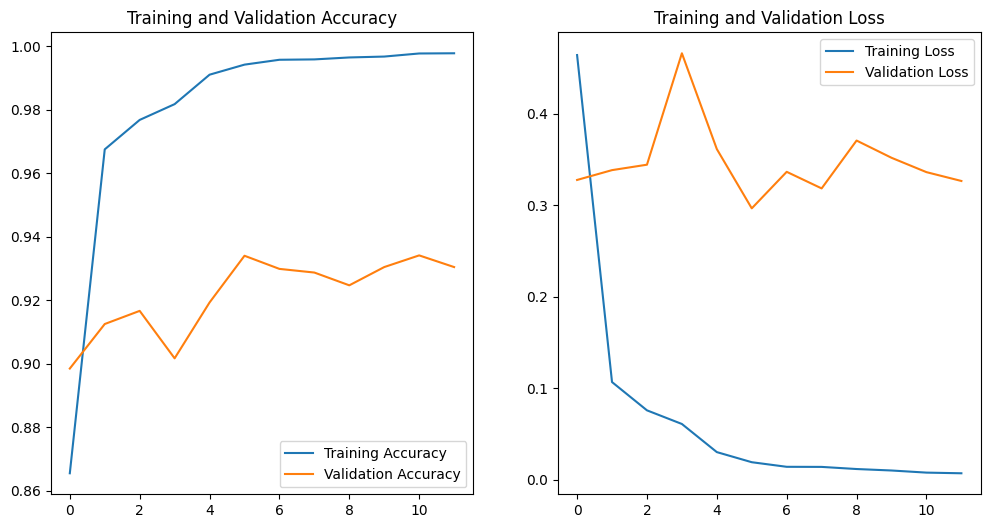

In [9]:
# ==============================
# 6. PLOT TRAINING HISTORY (NEW SECTION)
# ==============================
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.show()

plot_history(history)


272/272 ━━━━━━━━━━━━━━━━━━━━ 45s 164ms/step - accuracy: 0.9658 - loss: 0.1489

Validation Set - Accuracy: 0.9308, Loss: 0.3120
272/272 ━━━━━━━━━━━━━━━━━━━━ 50s 169ms/step


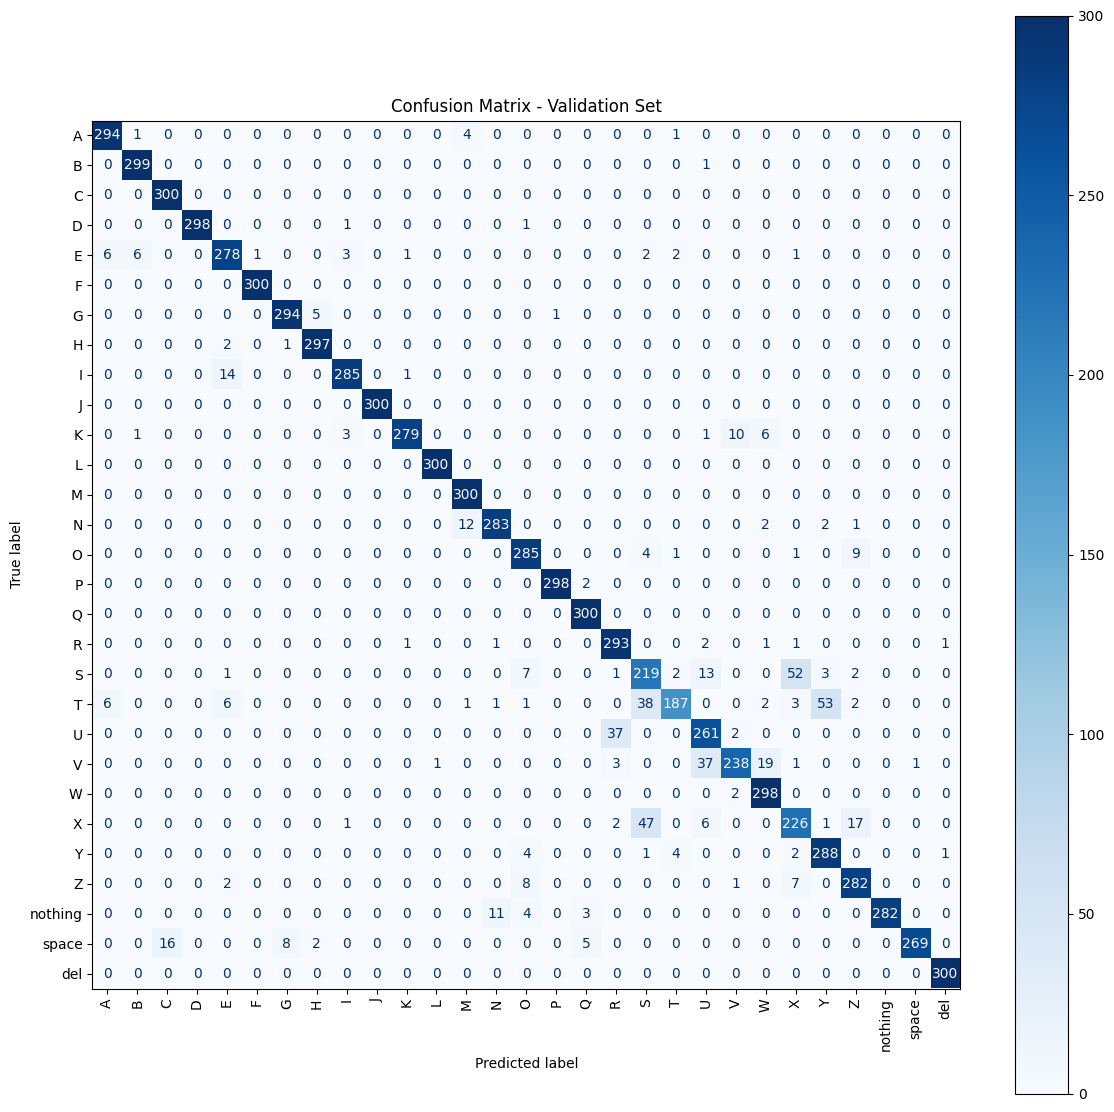


CLASSIFICATION REPORT - Validation Set
              precision    recall  f1-score   support

           A       0.96      0.98      0.97       300
           B       0.97      1.00      0.99       300
           C       0.95      1.00      0.97       300
           D       1.00      0.99      1.00       300
           E       0.92      0.93      0.92       300
           F       1.00      1.00      1.00       300
           G       0.97      0.98      0.98       300
           H       0.98      0.99      0.98       300
           I       0.97      0.95      0.96       300
           J       1.00      1.00      1.00       300
           K       0.99      0.93      0.96       300
           L       1.00      1.00      1.00       300
           M       0.95      1.00      0.97       300
           N       0.96      0.94      0.95       300
           O       0.92      0.95      0.93       300
           P       1.00      0.99      0.99       300
           Q       0.97      1.00      0.

In [10]:
# ==============================
# 7. EVALUATION ON VALIDATION SET
# ==============================
def evaluate_generator(generator, title="Dataset"):
    loss, acc = model.evaluate(generator, verbose=1)
    print(f"\n{title} - Accuracy: {acc:.4f}, Loss: {loss:.4f}")

    y_pred = model.predict(generator, verbose=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = generator.classes

    cm = confusion_matrix(y_true_labels, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    
    plt.figure(figsize=(14, 14))
    disp.plot(xticks_rotation='vertical', cmap='Blues', ax=plt.gca())
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    print(f"\nCLASSIFICATION REPORT - {title}")
    print(classification_report(y_true_labels, y_pred_labels, target_names=classes))

evaluate_generator(val_generator, title="Validation Set")

In [11]:
# ==============================
# 8. LOAD EXTERNAL TEST DATA
# ==============================
def load_external_test_data(test_dir, img_size=(128, 128)):
    images, labels = [], []
    
    if not os.path.exists(test_dir):
        print(f"Error: Directory {test_dir} not found.")
        return np.array([]), np.array([])

    for folder in os.listdir(test_dir):
        if folder not in classes:
            continue
            
        label_idx = classes.index(folder)
        folder_path = os.path.join(test_dir, folder)
        
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            
            img = cv2.imread(img_path)
            
            if img is None:
                continue
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            
            # ResNet Preprocessing
            img = img.astype('float32')
            img = preprocess_input(img) 
            
            images.append(img)
            labels.append(label_idx)
            
    images = np.array(images)
    labels = to_categorical(labels, num_classes=num_classes)
    
    print(f"\nLoaded {images.shape[0]} external test images. Shape = {images.shape}")
    return images, labels

x_test_external, y_test_external = load_external_test_data(external_test_dir, img_size=input_shape[:2])




Loaded 870 external test images. Shape = (870, 128, 128, 3)


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.4081 - loss: 5.1688

External Test Set - Accuracy: 0.4299, Loss: 4.4338
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step


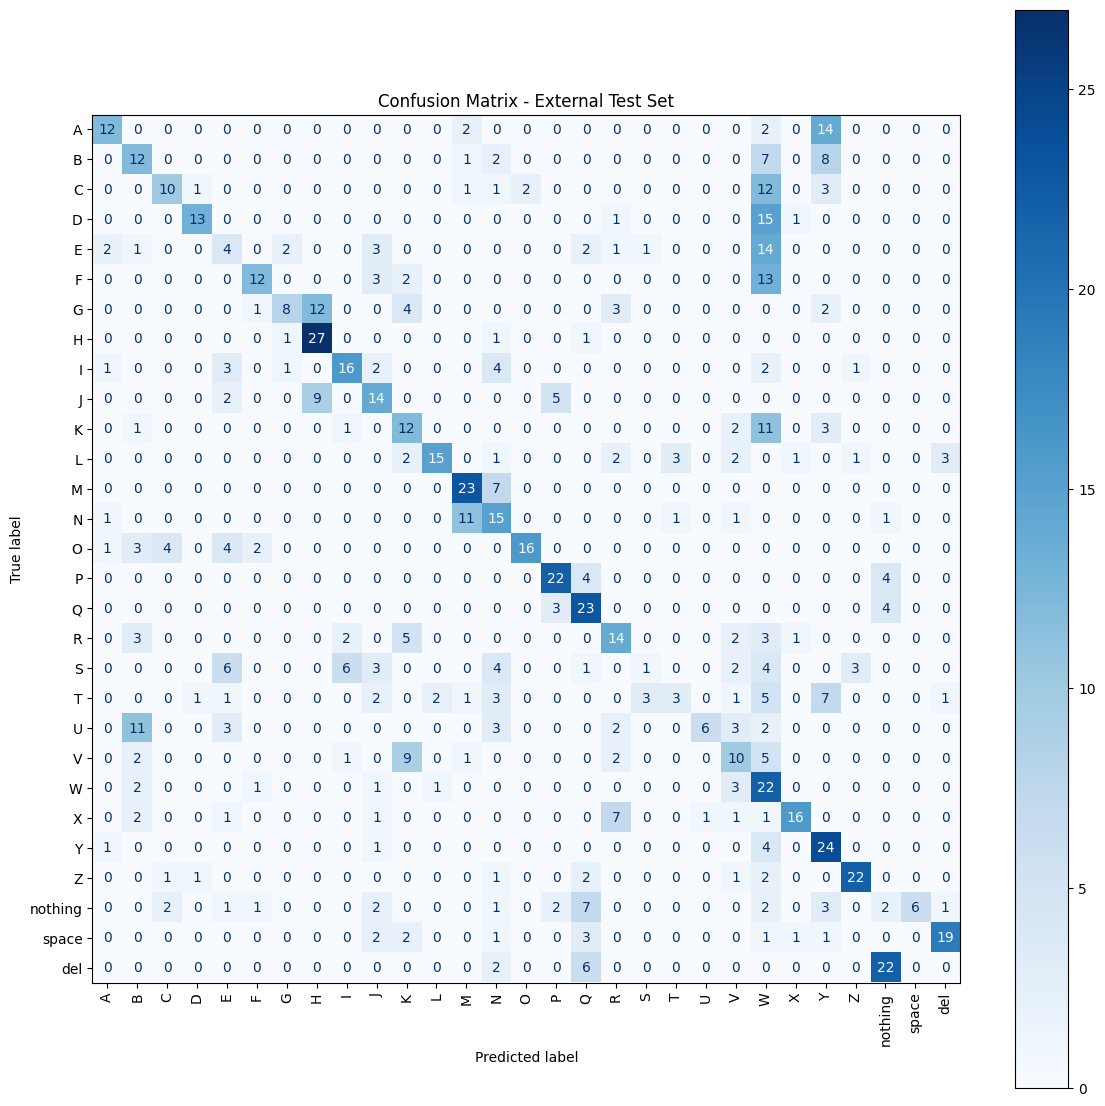


CLASSIFICATION REPORT - External Test Set
              precision    recall  f1-score   support

           A       0.67      0.40      0.50        30
           B       0.32      0.40      0.36        30
           C       0.59      0.33      0.43        30
           D       0.81      0.43      0.57        30
           E       0.16      0.13      0.15        30
           F       0.71      0.40      0.51        30
           G       0.67      0.27      0.38        30
           H       0.56      0.90      0.69        30
           I       0.62      0.53      0.57        30
           J       0.41      0.47      0.44        30
           K       0.33      0.40      0.36        30
           L       0.83      0.50      0.62        30
           M       0.57      0.77      0.66        30
           N       0.33      0.50      0.39        30
           O       0.89      0.53      0.67        30
           P       0.69      0.73      0.71        30
           Q       0.47      0.77     

In [12]:
# ==============================
# 9. EVALUATE ON EXTERNAL TEST SET
# ==============================
def evaluate_on_arrays(x_data, y_data, title="External Test Set"):
    if x_data.size == 0:
        print("No data to evaluate.")
        return

    loss, acc = model.evaluate(x_data, y_data, verbose=1)
    print(f"\n{title} - Accuracy: {acc:.4f}, Loss: {loss:.4f}")

    y_pred = model.predict(x_data, verbose=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_data, axis=1)

    cm = confusion_matrix(y_true_labels, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    
    plt.figure(figsize=(14, 14))
    disp.plot(xticks_rotation='vertical', cmap='Blues', ax=plt.gca())
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    print(f"\nCLASSIFICATION REPORT - {title}")
    print(classification_report(y_true_labels, y_pred_labels, target_names=classes))

evaluate_on_arrays(x_test_external, y_test_external, title="External Test Set")